In [1]:
from dash import Dash, dcc, html, Input, Output, callback
import dash_daq as daq
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt

In [2]:
# array for drawing circle, polar coordinates
theta = np.linspace( 0 , 2 * np.pi , 150 )

# wavelength range
wavelength = np.linspace(1500e-9, 1600e-9, 1000)

# coupling + attenuation coefficients
r1 = .85
r2 = .85
a = 1

# transmission functions
def transmission_add(r1, r2, a, p):
    return (
        ((r2**2*a**2)-(2*r1*r2*a*np.cos(p))+(r1**2))/(1-(2*r1*r2*a*np.cos(p))+((r1*r2*a)**2))
    )

def transmission_drop(r1, r2, a, p):
    return (
    ((1-(r1**2))*(1-(r2**2))*a)/(1-(2*r1*r2*a*np.cos(p))+(r1*r2*a)**2)
    )

# vectorize functions to operate over arrays
transmission_add = np.vectorize(transmission_add)
transmission_drop = np.vectorize(transmission_drop)

# adjust radius of ring - path length
def ring_size(rad):
    a = rad * np.cos( theta )
    b = rad * np.sin( theta )
    return a, b


app = Dash(__name__)

app.layout = html.Div([
    html.Div(
        children=[
        dcc.Graph(id='graph-with-slider'),
        ],
        style={"width": "49%", "display": "inline-block"}
    ),
    html.Div(
        children=[
        dcc.Graph(id='graph2-with-slider'),
        ],
        style={"width": "49%", "display": "inline-block"}
    ),
    html.Div([
        html.Div(
            children = [
                html.H3("FSR: "),
                html.H2(id="FSR")
            ],
            style={"width": "49%", "display": "inline-block"}),
        html.Div(
            children = [
                html.H3("Q-Factor: "),
                html.H2(id="Q")
            ],
            style={"width": "49%", "display": "inline-block"})
    ]),
    
    
    #radius input - will affect path length and therefore phase shift
    html.H3("Ring Radius",
               style={"padding-bottom":"10px"}),
    dcc.Slider(
        4,
        14,
        step=.1,
        value=5,
        marks=None,
        tooltip={"placement": "bottom", "always_visible": True},
        id='slider'
    ),
    html.Div(
        children = [
        html.H3("Attenuation Coefficient (a)",
        style={"padding-bottom":"10px"}),
            dcc.Slider(
                0,
                1,
                step=.05,
                value=.85,
                marks=None,
                tooltip={"placement": "bottom", "always_visible": True},
                id='slider2'
            )
        ],
        style={"width": "50%", "display": "inline-block"}
    ),
    html.Div(
        children = [
            html.H3("Coupling Coefficient (r1)",
               style={"padding-bottom":"10px"}),
            dcc.Slider(
                0,
                1,
                step=.05,
                value=.85,
                marks=None,
                tooltip={"placement": "bottom", "always_visible": True},
                id='slider3'
            )
        ],
        style={"width": "25%", "display": "inline-block"}
    ),
    html.Div(
        children = [
            html.H3("Coupling Coefficient (r2)",
               style={"padding-bottom":"10px"}),
            dcc.Slider(
                0,
                1,
                step=.05,
                value=.85,
                marks=None,
                tooltip={"placement": "bottom", "always_visible": True},
                id='slider4'
            )
        ],
        style={"width": "25%", "display": "inline-block"}
    )
])


@callback(
    Output('graph-with-slider', 'figure'),
    Output('graph2-with-slider', 'figure'),
    Output('FSR', 'children'),
    Output('Q', 'children'),
    Input('slider', 'value'),
    Input('slider2', 'value'),
    Input('slider3', 'value'),
    Input('slider4', 'value')

)
def update_figure(value, a, r1, r2):
    
    data = ring_size(value)
    
    # path length -> circumference -> 2 * pi * radius (um)
    path_length = 2*np.pi*(value)*1e-6
    # propagation constant -> 2*pi*neff/wavelength NOTE: neff is currently not included, need to tweak
    k = (2*np.pi)/wavelength
    # phase shift = k * L
    phase_shift = k * path_length
    
    # compute points for transmission at 1550nm
    k_1550nm = (2*np.pi)/1550e-9
    ps_1550nm = k_1550nm * path_length
    
    attenuation_distance = 2*(1-a)
    
    FSR = (1550e-9)**2/path_length
    FSR_text = f'{FSR:.2e}'
    
    Q = (pi*path_length*sqrt(r1*r2*a))/(1550e-9*(1-(r1*r2*a)))
    Q_text = f'{round(Q,2)}'
    
    
    transmission_colors = {
            "add_color": "black",
            "drop color": "blue"
        }  
    
    if((a*r2) == r1):
        transmission_colors.update([
                ("add_color", "green"),
                ("drop_color", "green")
            ])
    else:
        transmission_colors.update([
            ("add_color", "black"),
            ("drop_color", "blue")
        ])


    
    fig = make_subplots(rows=1, cols=2)
    
    fig = go.Figure(
    data=[
        go.Scatter(x=data[0], y=data[1]),
        go.Scatter(x=[-value, value], y=[0, 0]),
        go.Scatter(x=[-80, 80], y=[value+attenuation_distance, value+attenuation_distance]),
        go.Scatter(x=[-80, 80], y=[-value-attenuation_distance, -value-attenuation_distance])
    ],
    layout=go.Layout(
        xaxis=dict(range=[-25, 25], autorange=False, showticklabels=False),
        yaxis=dict(range=[-25, 25], autorange=False, showticklabels=False),
        title="Ring Radius"
    )
    )
    
    fig.add_trace(go.Scatter(
        x=[0, 0],
        y=[0, 0],
        mode="text",
        name="Text",
        text=[f'{value} um'],
        textposition="top center",
        textfont=dict(family="Arial Black")
        )
    )
    
    fig.add_annotation(
        x=10,
        y=value,
        xref="x",
        yref="y",
        text=f'Transmission (Through Port): \n {round(transmission_add(r1, r2, a, ps_1550nm)*100, 2)}%',
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=0,
        ay=-60,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#40456b",
        opacity=0.8
        )
    
    fig.add_annotation(
        x=-10,
        y=-value,
        xref="x",
        yref="y",
        text=f'Transmission (Drop Port): \n {round(transmission_drop(r1, r2, a, ps_1550nm)*100, 2)}%',
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=0,
        ay=60,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#40456b",
        opacity=0.8
        )

    fig.update_layout(transition_duration=100,
                     yaxis_scaleanchor="x",
                     template="plotly_white",
                     showlegend=False)
    fig.update_traces(marker=dict(color='#906fd9'))
    fig2 = go.Figure(
    data=[
        go.Scatter(x=wavelength, y=transmission_drop(r1, r2, a, phase_shift),
                   mode='lines',
                   line = dict(color = transmission_colors["drop_color"])),
        go.Scatter(x=wavelength, y=transmission_add(r1, r2, a, phase_shift),
                   mode='lines',
                   line = dict(shape = 'linear', color = transmission_colors["add_color"], width= 2, dash = 'dash')),
        go.Scatter(x=[1550e-9], y=[transmission_drop(r1, r2, a, ps_1550nm)]),
        go.Line(
            x=[1500e-9, 1550e-9], 
            y=[transmission_drop(r1, r2, a, ps_1550nm),
               transmission_drop(r1, r2, a, ps_1550nm)],
            mode='lines',
            line = dict(shape = 'linear', color = 'black', width= 2, dash = 'dash')
        ),
        go.Line(
            x=[1550e-9, 1550e-9], 
            y=[0,
               transmission_drop(r1, r2, a, ps_1550nm)],
            mode='lines',
            line = dict(shape = 'linear', color = 'black', width= 2, dash = 'dash')
        )
    ])
    
    fig2.update_layout(
        transition_duration=100,
        template="plotly_white",
        title="Transmission",
        xaxis_title="Wavelength (um)",
        yaxis_title="Transmission (%)",
        showlegend=False
    )
    
    fig2.update_yaxes(range=[0, 1])

    return fig, fig2, FSR_text, Q_text


if __name__ == '__main__':
    app.run(debug=True)

C:\Users\elibr\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




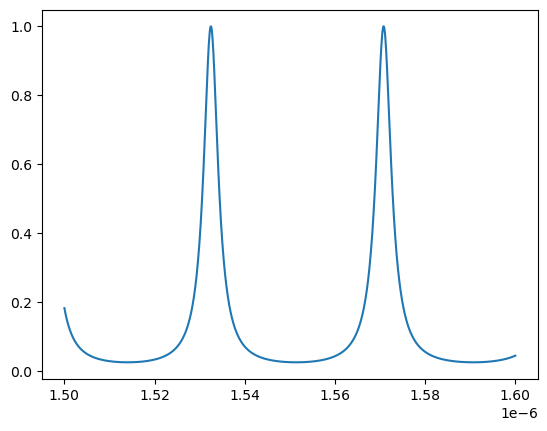

In [8]:
# array for drawing circle, polar coordinates
theta = np.linspace( 0 , 2 * np.pi , 150 )


# coupling + attenuation coefficients
r1 = .85
r2 = .85
a = 1

# wavelength range
wavelength = np.linspace(1500e-9, 1600e-9, 1000)
path_length = 2*np.pi*(10)*1e-6
k = (2*np.pi)/wavelength

phase_shift = k * path_length

plt.plot(wavelength, transmission_drop(r1, r2, a, phase_shift))